In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
# from inversions_1d import create_inversion, run_inv

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# load data 

In [4]:
n_times_invert = 20

In [5]:
rx_locs = np.load("rx_locs.npy")

In [6]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [7]:
dobs = load_pre_file("dpred0.txt")

In [8]:
rx_times = np.array([dobs["transmitters"][0]["receivers"][j]["time"] for j in range(len(dobs["transmitters"][0]["receivers"]))])

In [9]:
rx_times

array([2.00000000e-05, 2.54854997e-05, 3.24755348e-05, 4.13827616e-05,
       5.27330180e-05, 6.71963657e-05, 8.56266480e-05, 1.09111896e-04,
       1.39038559e-04, 1.77173358e-04, 2.25767578e-04, 2.87689978e-04,
       3.66596142e-04, 4.67144294e-04, 5.95270288e-04, 7.58538038e-04,
       9.66586048e-04, 1.23169642e-03, 1.56951994e-03, 2.00000000e-03])

In [10]:
n_times_invert = len(rx_times)

# create survey

In [11]:
tx_height = 30
source_list = []

for i in range(rx_locs.shape[0]):
    loc_above_topo = np.r_[rx_locs[i, 0], rx_locs[i, 1], tx_height]
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(loc_above_topo, rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=loc_above_topo, orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [12]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-1]

In [13]:
observed_data = Data(survey=full_survey, dobs=-discretize.utils.mkvc(dobs_values))

In [14]:
ind = int(len(full_survey.source_list)/2)
rx_locs[ind, :]

array([  0.,   0., 230.])

In [15]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")
model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "halfspace.con")

In [16]:
len(full_survey.source_list)

465

In [17]:
src_ind = int((len(full_survey.source_list) -1 )/2)
src_ind

232

In [18]:
topo = np.loadtxt("topo.txt", skiprows=1)

In [19]:
topo_side = int(np.sqrt(len(topo)))

In [20]:
topo_square = topo[:, 2].reshape(topo_side, topo_side)
topo_x = np.unique(topo[:, 0])

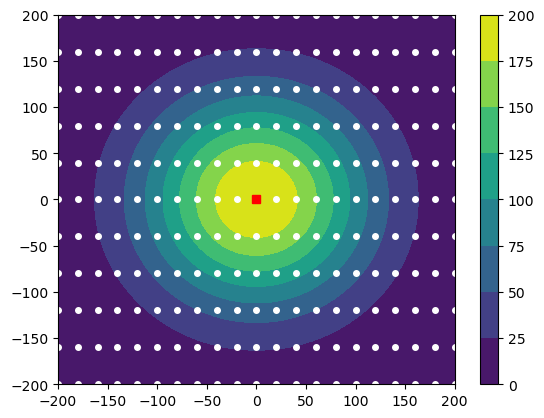

In [21]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ax.contourf(topo_x, topo_x, topo_square))
# plt.colorbar(
#     ubc_mesh.plot_slice(
#         model, ax=ax, pcolor_opts={"norm":LogNorm()}, 
#         normal="Z", ind=2936
#     )[0], 
#     ax=ax
# )

ax.set_xlim(200*np.r_[-1, 1])
ax.set_ylim(200*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax.plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)

In [22]:
observed_data[src, src.receiver_list[0]]

array([-1.381512e-07, -7.985842e-08, -4.467441e-08, -2.634738e-08,
       -1.538186e-08, -8.833043e-09, -5.017158e-09, -2.825445e-09,
       -1.541798e-09, -8.879358e-10, -5.015870e-10, -2.801800e-10,
       -1.556735e-10, -8.398610e-11, -4.763029e-11, -2.661109e-11,
       -1.470450e-11, -7.922808e-12, -4.505973e-12, -2.507886e-12])

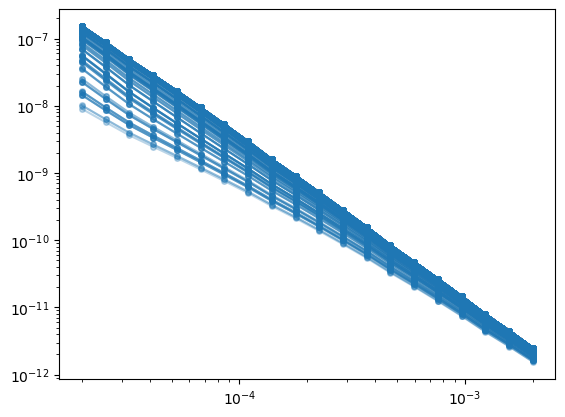

In [23]:
# plt.loglog(rx_times, -dpred_halfspace, "k-o", ms=4, label="halfspace")
for src_ind in range(len(rx_locs)): 
    src = full_survey.source_list[src_ind]
    
    # plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
    plt.loglog(rx_times, -observed_data[src, src.receiver_list[0]], "C0-o", ms=4, alpha=0.3)
    


In [24]:
src.location

array([300., 280.,  30.])

In [25]:
# target_z_center = -60
# target_thickness = 40

In [26]:
src_ind = int(len(rx_locs)/2)
src_ind = 96

In [27]:
source_sounding = full_survey.source_list[src_ind]
source_sounding.location

array([-240., -160.,   30.])

In [28]:
survey_sounding = tdem.Survey([source_sounding])
sim1d_true = tdem.Simulation1DLayered(
    survey=survey_sounding, thicknesses=[], sigmaMap=maps.IdentityMap(nP=1)
)

In [29]:
dpred_halfspace = sim1d_true.dpred(1./500*np.ones(1))

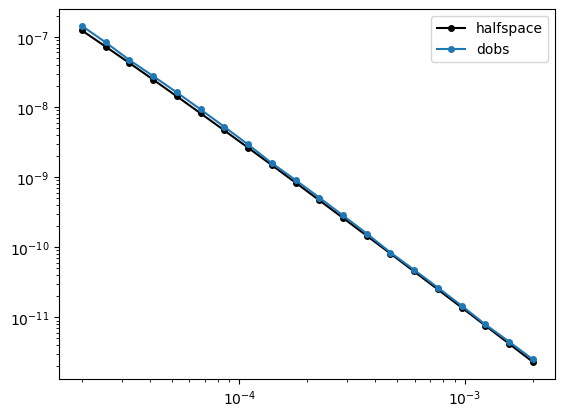

In [30]:
fig, ax = plt.subplots(1, 1)

ax.loglog(rx_times, -dpred_halfspace, "k-o", ms=4, label="halfspace")
ax.loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0-o", ms=4, label="dobs")

ax.legend()

In [31]:
# octree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

# octree_mesh = discretize.load_mesh()

In [32]:
cs = 10
core_region = 200
npad = 100
padding_factor = 1

thicknesses1d = discretize.utils.unpack_widths(
    [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
)

In [33]:
np.sum(thicknesses1d)


np.float64(1200.0)

In [34]:
# set up 1D inversion 
def create_inversion(
    ind,
    dobs,
    rx_times_invert=rx_times[:n_times_invert],
    rx_locs=rx_locs, 
    relative_error=0.02,
    noise_floor=1e-13,
    alpha_s = 1e-1,
    alpha_x = 1,
    rho_back = 500,
    beta0 = 1000,
): 
    cs = 10
    core_region = 200
    npad = 100
    padding_factor = 1
    
    thicknesses1d = discretize.utils.unpack_widths(
        [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
    )

    loc_above_topo = np.r_[rx_locs[ind, 0], rx_locs[ind, 1], tx_height]
    rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=loc_above_topo, times=rx_times_invert, orientation="z"
    )
    src_sounding = tdem.sources.CircularLoop(
        receiver_list=[rx_sounding], location=loc_above_topo, orientation="z", 
        radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    survey_sounding = tdem.Survey([src_sounding])
    mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")
    
    sim1d = tdem.Simulation1DLayered(
        survey=survey_sounding, thicknesses=thicknesses1d, sigmaMap=maps.ExpMap(mesh_invert)
    )

    data_invert = Data(
        survey_sounding, 
        dobs=dobs,
        standard_deviation=relative_error*np.abs(dobs) + noise_floor
    )
    
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh_invert, alpha_s=alpha_s, alpha_x=alpha_x, 
        # reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=20)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=beta0)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    
    cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    # Update the preconditionner
    update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=False,
    )
    
    
    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        sensitivity_weights,
        update_jacobi,
        # starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [35]:
len(rx_locs)

465

In [36]:
ind = 95
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], 
    rx_times[:n_times_invert], rx_locs
)

In [37]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+03  3.13e+02  0.00e+00  3.13e+02    1.94e+03      0              
   1  6.67e+02  2.81e+01  4.22e-02  5.63e+01    2.06e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.1356e+01
1 : |xc-x_last| = 1.7715e

In [38]:
iterations = len(inv.directiveList.dList[-2].outDict)

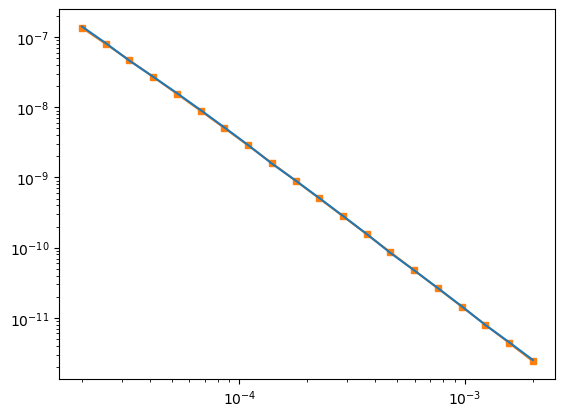

In [39]:

# plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
rx_times_invert = rx_times[:n_times_invert]
plt.errorbar(rx_times_invert, -inv.invProb.dmisfit[0][1].data.dobs, yerr=inv.invProb.dmisfit[0][1].data.standard_deviation)
plt.loglog(rx_times_invert, -inv.directiveList.dList[-2].outDict[iterations]["dpred"], "C1-s", ms=4)

(0.0001, 0.01)

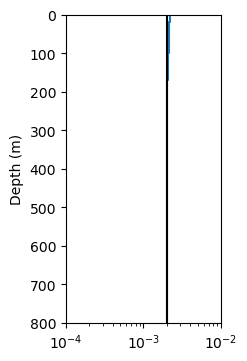

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
ax.plot(np.r_[1, 1]*1/500, [np.sum(thicknesses1d), 0], color="k")
ax.set_ylim([800, 0])
ax.set_xlim([1e-4, 1e-2])


In [41]:

ind = 0
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], rx_times[:n_times_invert], rx_locs
)

In [42]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)



Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+03  1.90e+02  0.00e+00  1.90e+02    1.52e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.9077e+01
1 : |xc-x_last| = 2.5455e-01 <= tolX*(1+|x0|) = 6.9361e+00
0 : |proj(x-g)-x|    = 1.5222e+03 <= tolG   

(0.0001, 0.1)

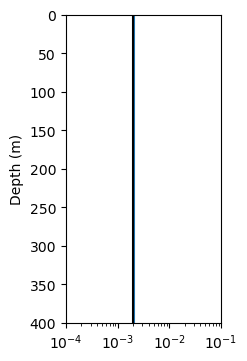

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
ax.plot(np.r_[1, 1]*1/500, [np.sum(thicknesses1d), 0], color="k")

ax.set_ylim([400, 0])
ax.set_xlim([1e-4, 1e-1])


In [44]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)

In [45]:
directory = "/t40array/lheagy/2025-heagy-et-al-tle/topo-halfspace"

In [46]:
def run_inv(ind, dobs, m0, directory=directory): 
    inv = create_inversion(ind, dobs)
    
    label_key=f"{ind}"
    
    mopt = inv.run(m0)
    np.save(f"{directory}/{label_key}_model.npy", mopt)
    
    inv_dict = inv.directiveList.dList[-2].outDict
    with open(f"{directory}/{label_key}_inv_dict.pkl", "wb") as f:
        pickle.dump(inv_dict, f)

    return label_key, mopt

In [47]:
ind=0
src = full_survey.source_list[ind]
rx = src.receiver_list[0]
run_inv(0, observed_data[src, rx], m0, directory)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+03  1.90e+02  0.00e+00  1.90e+02    1.52e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.9077e+01
1 : |xc-x_last| = 2.5455e-01 <= tolX*(1+|x0|) = 6.9361e+00
0 : |proj(x-g)-x|    = 1.5222e+03 <= tolG   

('0',
 array([-6.16623511, -6.16929882, -6.16873297, -6.1679449 , -6.16705704,
        -6.16622322, -6.16561601, -6.16539848, -6.16568252, -6.16649113,
        -6.16774881, -6.16931005, -6.17101015, -6.17271029, -6.17431962,
        -6.17579512, -6.17712925, -6.17833514, -6.17943436, -6.18044912,
        -6.18139816, -6.18229553, -6.18315081, -6.18397017, -6.18475753,
        -6.18551556, -6.18624644, -6.18695229, -6.18763537, -6.1882981 ,
        -6.18894298, -6.18957252, -6.19018909, -6.19079486, -6.19139175,
        -6.19198134, -6.19256494, -6.19314356, -6.19371794, -6.19428857,
        -6.19485579, -6.19541974, -6.19598045, -6.1965379 , -6.19709196,
        -6.19764254, -6.1981895 , -6.19873274, -6.1992722 , -6.19980786,
        -6.20033978, -6.20086804, -6.20139284, -6.20191443, -6.2024331 ,
        -6.20294926, -6.20346333, -6.20397581, -6.20448725, -6.20499823,
        -6.20550937, -6.2060213 , -6.20653468, -6.20705018, -6.20756845,
        -6.20809015, -6.20861592, -6.20914637

In [48]:
from joblib import Parallel, delayed
inv_dict = {}
results = Parallel(n_jobs=48, backend='loky')(  # 'loky' is the default and most flexible
    delayed(run_inv)(
        ind, observed_data[full_survey.source_list[ind], 
        full_survey.source_list[ind].receiver_list[0]], 
        m0, directory)
    for ind in range(rx_locs.shape[0])
)

# Collect results
for (label_key, mopt) in results:
    inv_dict[label_key] = mopt


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+03  2.10e+02  0.00e+00  2.10e+02    1.60e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.1102e+01
1 : |xc-x_last| = 2.6618e-01 <= tolX*(1+|x0|) = 6.9361e+00
0 : |proj(x-g)-x|    = 1.6024e+03 <= tolG   

In [61]:
def load_models_and_dicts(folder):
    inv_dicts = {}
    model_arrays = {}

    for fname in os.listdir(folder):
        full_path = os.path.join(folder, fname)

        if fname.endswith("_inv_dict.pkl"):
            key = fname.replace("_inv_dict.pkl", "")
            with open(full_path, "rb") as f:
                inv_dicts[key] = pickle.load(f)

        elif fname.endswith("_model.npy"):
            key = fname.replace("_model.npy", "")
            model_arrays[key] = np.load(full_path)

    return inv_dicts, model_arrays

In [62]:
inv_dicts, models_1d = load_models_and_dicts(directory)

In [63]:
mesh1d = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")


In [64]:
rx_x = np.unique(rx_locs[:, 0])
rx_y = np.unique(rx_locs[:, 1])

In [65]:
topo_max = topo.max()

In [66]:
grid_1d_results = discretize.utils.ndgrid(
    rx_x, rx_y, -mesh1d.cell_centers
)

In [67]:
# compiled_1d_models = np.zeros(len(grid_1d_results))

# for key in models_1d.keys():
#     ind = int(key)
#     m = models_1d[key]
#     sounding_inds = (
#         (rx_locs[ind, 0] == grid_1d_results[:, 0]) & 
#         (rx_locs[ind, 1] == grid_1d_results[:, 1])
#     )
#     compiled_1d_models[sounding_inds] = np.flipud(m)

In [68]:
hx = np.diff(rx_x)
hx = np.r_[hx, hx[-1]]
hy = np.diff(rx_y)
hy = np.r_[hy, hy[-1]]

mesh_results = discretize.TensorMesh(
    [hx, hy, np.hstack([np.flipud(mesh1d.h[0]), cs*np.ones(int(topo_max/cs))])], origin="CCN"
)
mesh_results.origin=mesh_results.origin + np.r_[0, 0, topo_max]

In [69]:
mesh_results

TensorMesh: 70,215 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     31       -310.00        310.00     20.00     20.00    1.00
   y     15       -300.00        300.00     40.00     40.00    1.00
   z    151     -1,210.00        300.00     10.00     10.00    1.00

In [70]:
ind

0

In [71]:
rx_locs[ind, :]

array([-300.        , -280.        ,   30.00038667])

In [73]:
compiled_1d_models = np.ones(mesh_results.n_cells)*np.log(1e-8)
compiled_1d_models[mesh_results.cell_centers[:, 2] < 0] = np.log(1/500)

for key in models_1d.keys():
    ind = int(key)
    m = models_1d[key]
    sounding_inds = (
        (rx_locs[ind, 0] == mesh_results.cell_centers[:, 0]) & 
        (rx_locs[ind, 1] == mesh_results.cell_centers[:, 1]) &
        (mesh_results.cell_centers[:, 2] < rx_locs[ind, 2] - tx_height) & 
        (mesh_results.cell_centers[:, 2] > -np.sum(thicknesses1d) + rx_locs[ind, 2] - tx_height - cs)
    )
    
    compiled_1d_models[sounding_inds] = np.flipud(m)


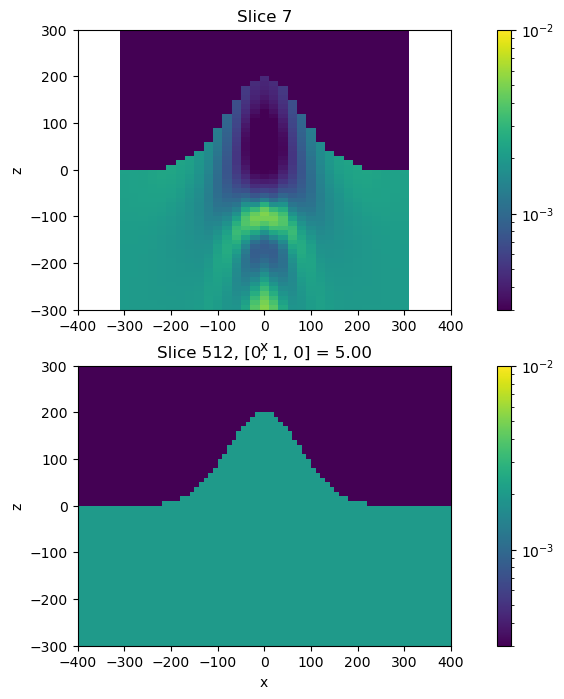

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

norm = LogNorm(vmin=3e-4, vmax=1e-2)
plt.colorbar(mesh_results.plot_slice(
    np.exp(compiled_1d_models),
    normal="Y", 
    pcolor_opts={"norm":norm},
    ax=ax[0],
    # ind=8
)[0], ax=ax[0])
# ax[0].plot(target_outline_x, target_outline_z, color="k", lw=1.5)

plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[1], pcolor_opts={"norm":norm}, 
        normal="Y",
    )[0], 
    ax=ax[1]
)


for a in ax.flatten():
    a.set_ylim(-300, 300)
    a.set_xlim(np.r_[-1, 1]*400)
    a.set_aspect(1)


In [75]:
dpred_1d = np.zeros((n_times_invert, len(rx_locs)))

for k in inv_dicts.keys():
    ind = int(k)
    
    idict = inv_dicts[k]
    iterations = len(idict)
    dpred_1d[:, ind] = idict[iterations]["dpred"]

    

In [ ]:
dpred_1d = dpred_1d.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

In [ ]:
fig, ax = plt.subplots(1, 1)

line_number = 0

ax.semilogy(
    rx_x, -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :], 
    "k-", ms=3
);

ax.semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C0o", ms=3);

In [ ]:
mesh_results_3d=discretize.TensorMesh(
    [mesh_results.h[0], [(10,400)], mesh_results.h[1]], 
    origin = "CCN"
)

In [ ]:
mapping_to_3d = maps.Surject2Dto3D(mesh_results_3d)

In [ ]:
results3d = mapping_to_3d * compiled_1d_models

In [ ]:
# # tmp = compiled_1d_models.reshape(mesh_results.shape_cells[0], mesh_results.shape_cells[1], order="F")
# results3d = np.zeros(mesh_results_3d.n_cells)
# for i in range(mesh_results_3d.shape_cells[1]):
#     inds = mesh_results_3d.cell_centers[:, 1] == mesh_results_3d.cell_centers_y[i]
#     results3d[inds] = compiled_1d_models


In [ ]:
norm = LogNorm(vmin=3e-4, vmax=6e-2)
fig, ax = plt.subplots(1, 1)
mesh_results_3d.plot_slice(
    np.exp(results3d), 
    pcolor_opts={"norm":norm},
    normal="Y",
    ind=0,
    ax=ax
)


ax.set_ylim([-400, 0])


In [ ]:
P = discretize.utils.volume_average(mesh_results_3d, ubc_mesh)

In [ ]:
interpolated_model = P * results3d
interpolated_model[ubc_mesh.cell_centers[:, 2]>0] = np.log(1e-8)

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ubc_mesh.plot_slice(
    np.exp(interpolated_model),
    pcolor_opts = {"norm": LogNorm(3e-4, 1e-1)},
    ax=ax,
    normal="y"
)[0], ax=ax)

ax.set_xlim(np.r_[-1, 1]*500)
ax.set_ylim(np.r_[-500, 100])

In [ ]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [ ]:
sim_directory_3d = "3D-sim-1d-results"

In [ ]:
discretize.TreeMesh.write_model_UBC(ubc_mesh, f"{sim_directory_3d}/model.con", np.exp(interpolated_model))

In [ ]:
# load and plot dpred, 1D inversion dpred, 3D simulation dpred

In [ ]:
dpred_from_3d = load_pre_file(f"{sim_directory_3d}/dpred0.txt")
dpred_values = np.zeros((n_times_invert, len(dobs["transmitters"])))

for i in range(len(dpred_from_3d["transmitters"])): 
    for j in range(n_times_invert): 
        dpred_values[j, i] = dpred_from_3d["transmitters"][i]["receivers"][j]["data"][-1]

In [ ]:
dpred_values = dpred_values.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

line_number = 0

true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
ax[0].semilogy(
    rx_x, true_data, 
    "ko", ms=3
);

ax[0].semilogy(rx_x, dpred_values[:, :, line_number].T, "C0-");


ax[1].semilogy(
    rx_x, np.abs(true_data-dpred_values[:, :, line_number].T),
    "C0-o", ms=3
);



In [ ]:
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# line_number = 4

# true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
# ax[0].semilogy(
#     rx_x, true_data, 
#     "ko", ms=3
# );

# ax[0].semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C1-");


# ax[1].semilogy(
#     rx_x, np.abs(true_data+dpred_1d[:, :, line_number].T),
#     "C1-o", ms=3
# );



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.semilogy(
    rx_x, np.abs(true_data+dpred_1d[:, :, line_number].T),
    "C1-o", ms=3
);

ax.semilogy(
    rx_x, np.abs(true_data-dpred_values[:, :, line_number].T),
    "C0-o", ms=3
);

In [ ]:
len(rx_locs)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

src_ind = 30
source_sounding = source_list[src_ind]

plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[0], pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=2937
    )[0], 
    ax=ax[0]
)

ax[0].set_xlim(600*np.r_[-1, 1])
ax[0].set_ylim(400*np.r_[-1, 1])
ax[0].set_aspect(1)

ax[0].plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax[0].plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)


# ax[1].loglog(rx_times, -dpred_halfspace, "k-", ms=4, label="halfspace", alpha=0.2)
ax[1].loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0o", ms=6, label="dobs")
ax[1].loglog(rx_times, -dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind], "C1-", label="dpred 1D inv")
ax[1].loglog(rx_times, dpred_values.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind], "C2-", label="dpred 3D fwd")
ax[1].grid()
ax[1].legend()

true = -observed_data[source_sounding, source_sounding.receiver_list[0]]
# ax[2].loglog(rx_times, , "C0o", ms=6, label="dobs")
ax[2].loglog(rx_times, np.abs(true + dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]), "C1-", label="dpred 1D inv")
ax[2].loglog(rx_times, np.abs(true-dpred_values.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]), "C2-", label="dpred 3D fwd")
ax[2].grid()
ax[2].legend()

for a in ax[1:].flatten():
    a.set_ylim([1e-12, 1e-7])

# ax.legend()

In [ ]:
dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]